In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Patch


# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the throughput data using rolling mean
def smooth_throughput(df, window_size=5):
    df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Create directory if it doesn't exist
output_dir = 'work_dealing_stealing_variable'
os.makedirs(output_dir, exist_ok=True)

custom_palette = ["#ba9344", "#7402d8"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='WORK_DEALING_NEW_QUEUE_AND_THREAD'),
    Patch(facecolor=custom_palette[1], label='WORK_STEALING')
]
hue_order = ['WORK_DEALING_NEW_QUEUE_AND_THREAD', 'WORK_STEALING']
labels = ['WORK DEALING', 'WORK STEALING']

    
df = pd.read_csv("throughput_results_nebulastream_concat.csv")
df['normalized_timestamp'] = df['normalized_timestamp'] / 1000
df

,normalized_timestamp,query_id,throughput,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType
0,0.0,4,1285.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE
1,0.0,2,1285.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE
2,0.0,3,1285.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE
3,0.0,1,2595.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE
4,0.2,1,1290.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19209,30.0,24,2555.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
19210,30.0,25,2555.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
19211,30.0,27,2555.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE
19212,30.0,22,2555.0,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE


/tmp/ipykernel_76657/3145220429.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


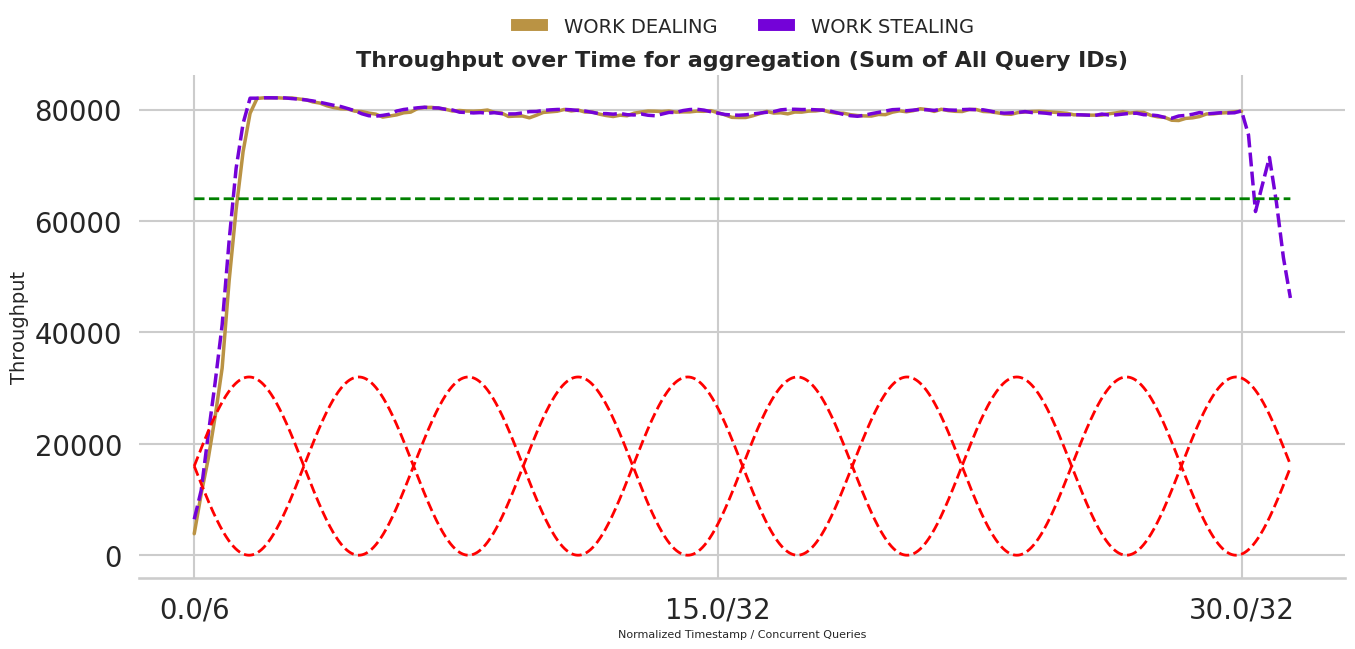

/tmp/ipykernel_76657/3145220429.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


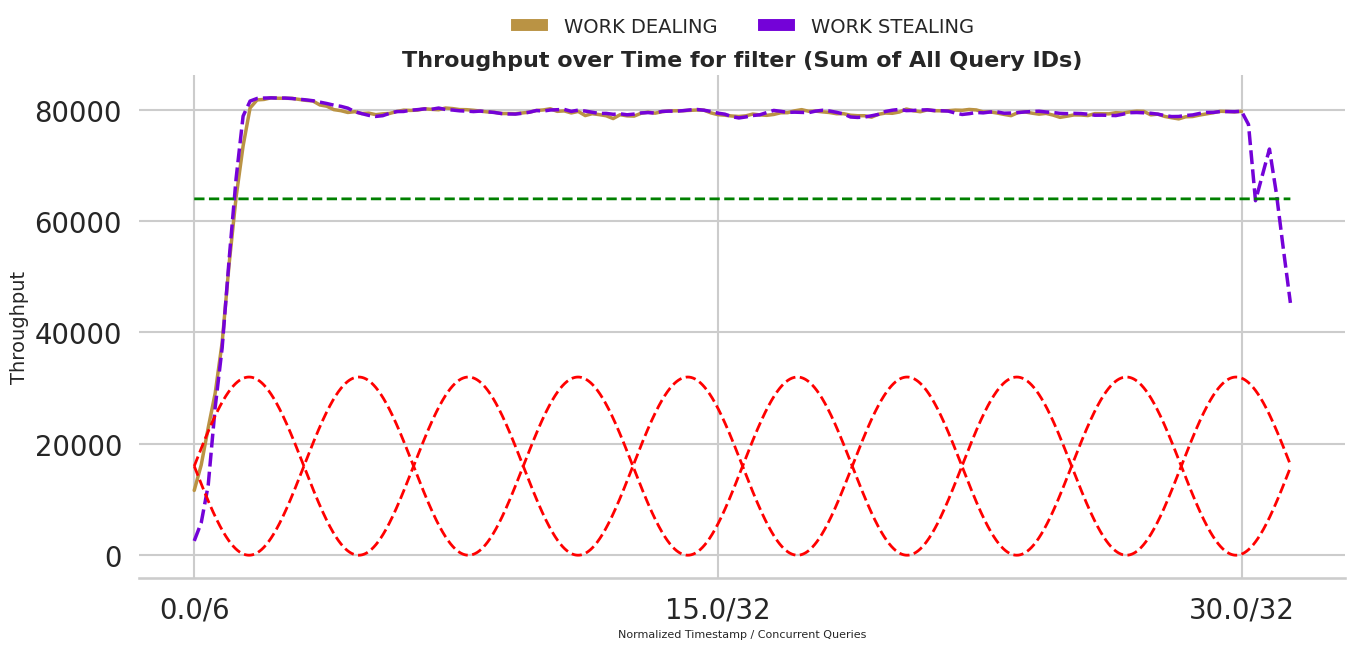

In [2]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).sum(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', palette=custom_palette, hue_order=hue_order, hue='resourceAssignment', style='resourceAssignment', linewidth=2.5)

    # Generate sine wave: frequency=1, amplitude=1000, offset=1000
    x_sin = np.linspace(0, smoothed_df['normalized_timestamp'].max(), 10000)
    freq = 1
    phase_shift = 0
    amplitude = 1000
    y_sin_1 = amplitude * (np.sin(freq * (x_sin - phase_shift))) + amplitude
    y_sin_2 = amplitude * (np.sin(-1 * freq * (x_sin - phase_shift)))  + amplitude
    y_sin_1 = y_sin_1 * 16
    y_sin_2 = y_sin_2 * 16
    y_sin_total = np.add(y_sin_1, y_sin_2) * 2

    # Plot sine wave
    plt.plot(x_sin, y_sin_1, color='red', linestyle='--', label='Sine Wave (f=1, A=1000, offset=1000)', linewidth=2)
    plt.plot(x_sin, y_sin_2, color='red', linestyle='--', label='Sine Wave (f=1, A=1000, offset=1000)', linewidth=2)
    plt.plot(x_sin, y_sin_total, color='green', linestyle='--', label='Sine Wave (f=1, A=1000, offset=1000)', linewidth=2)

    
    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 75
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    plt.title(f'Throughput over Time for {query} (Sum of All Query IDs)', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    #plt.legend(title='Resource Assignment', title_fontsize=12, fontsize=12)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False)        
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_variable_ingestion_rate.pdf'))
    plt.show()

/tmp/ipykernel_76657/3145220429.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


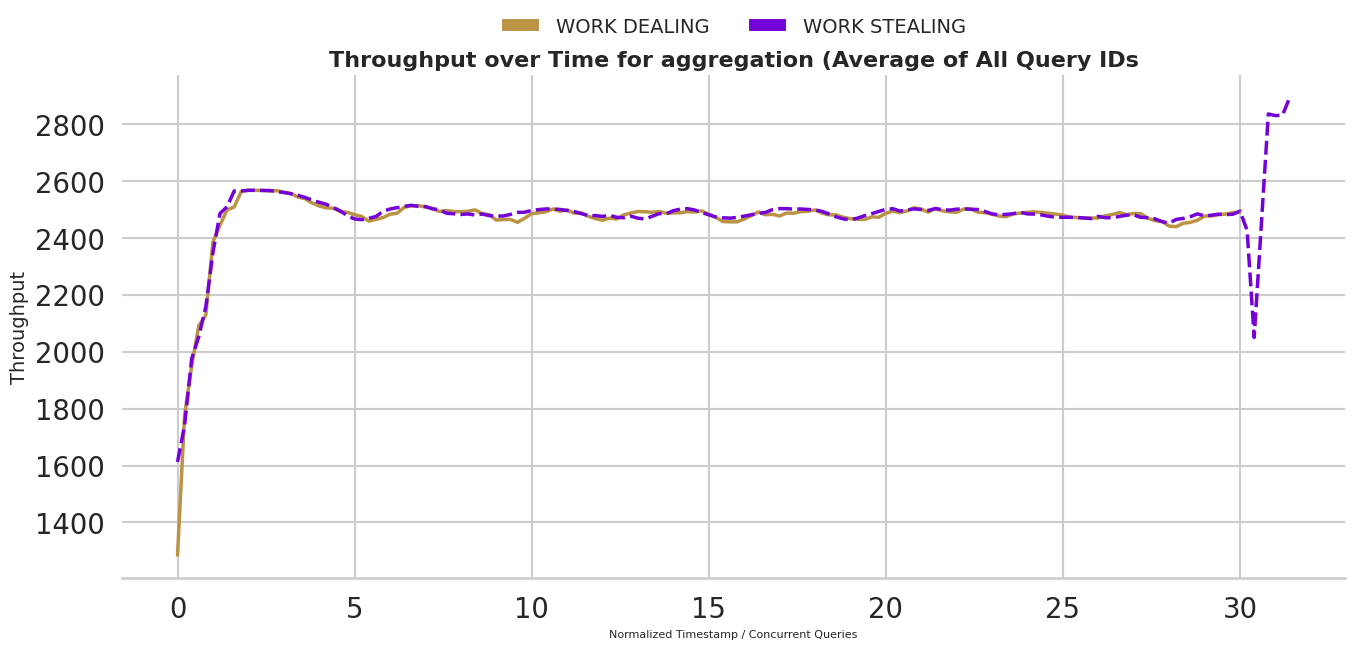

/tmp/ipykernel_76657/3145220429.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


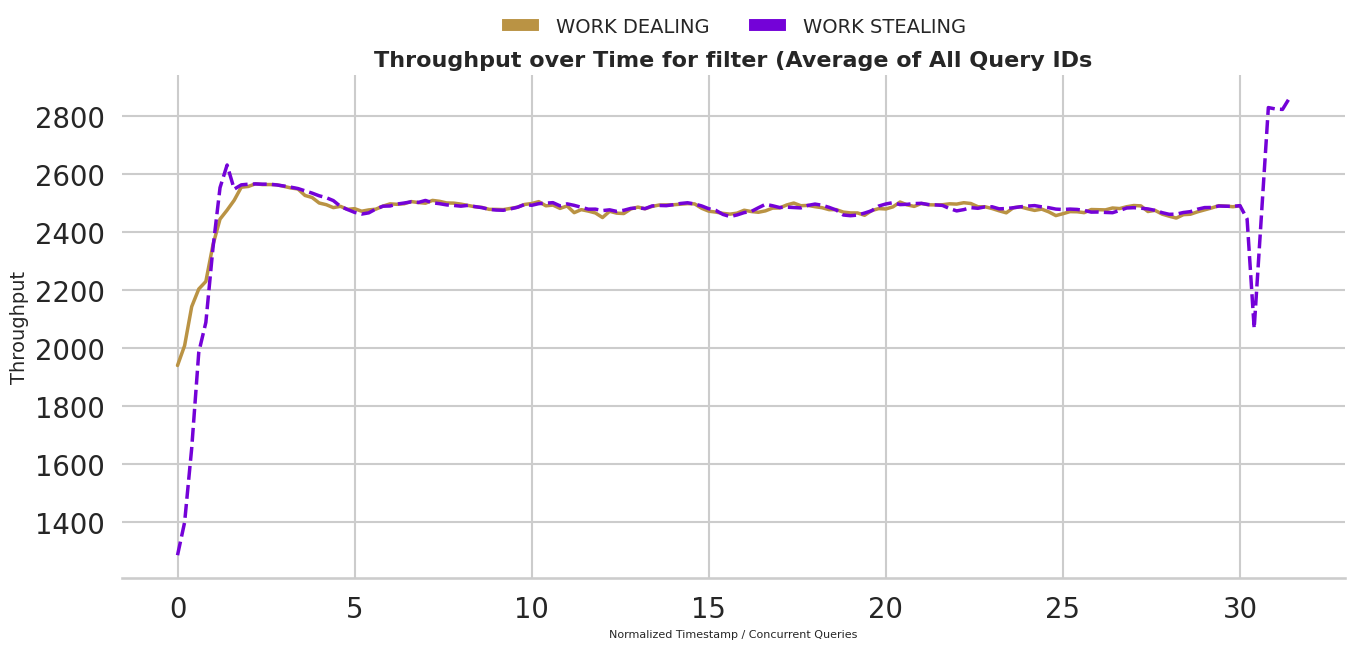

In [3]:
# Only keep timestamps smaller than n
#n = 600
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=2.5)

    plt.title(f'Throughput over Time for {query} (Average of All Query IDs', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_variable_ingestion_rate_throughput.pdf'))
    plt.show()

/tmp/ipykernel_76657/3071497265.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


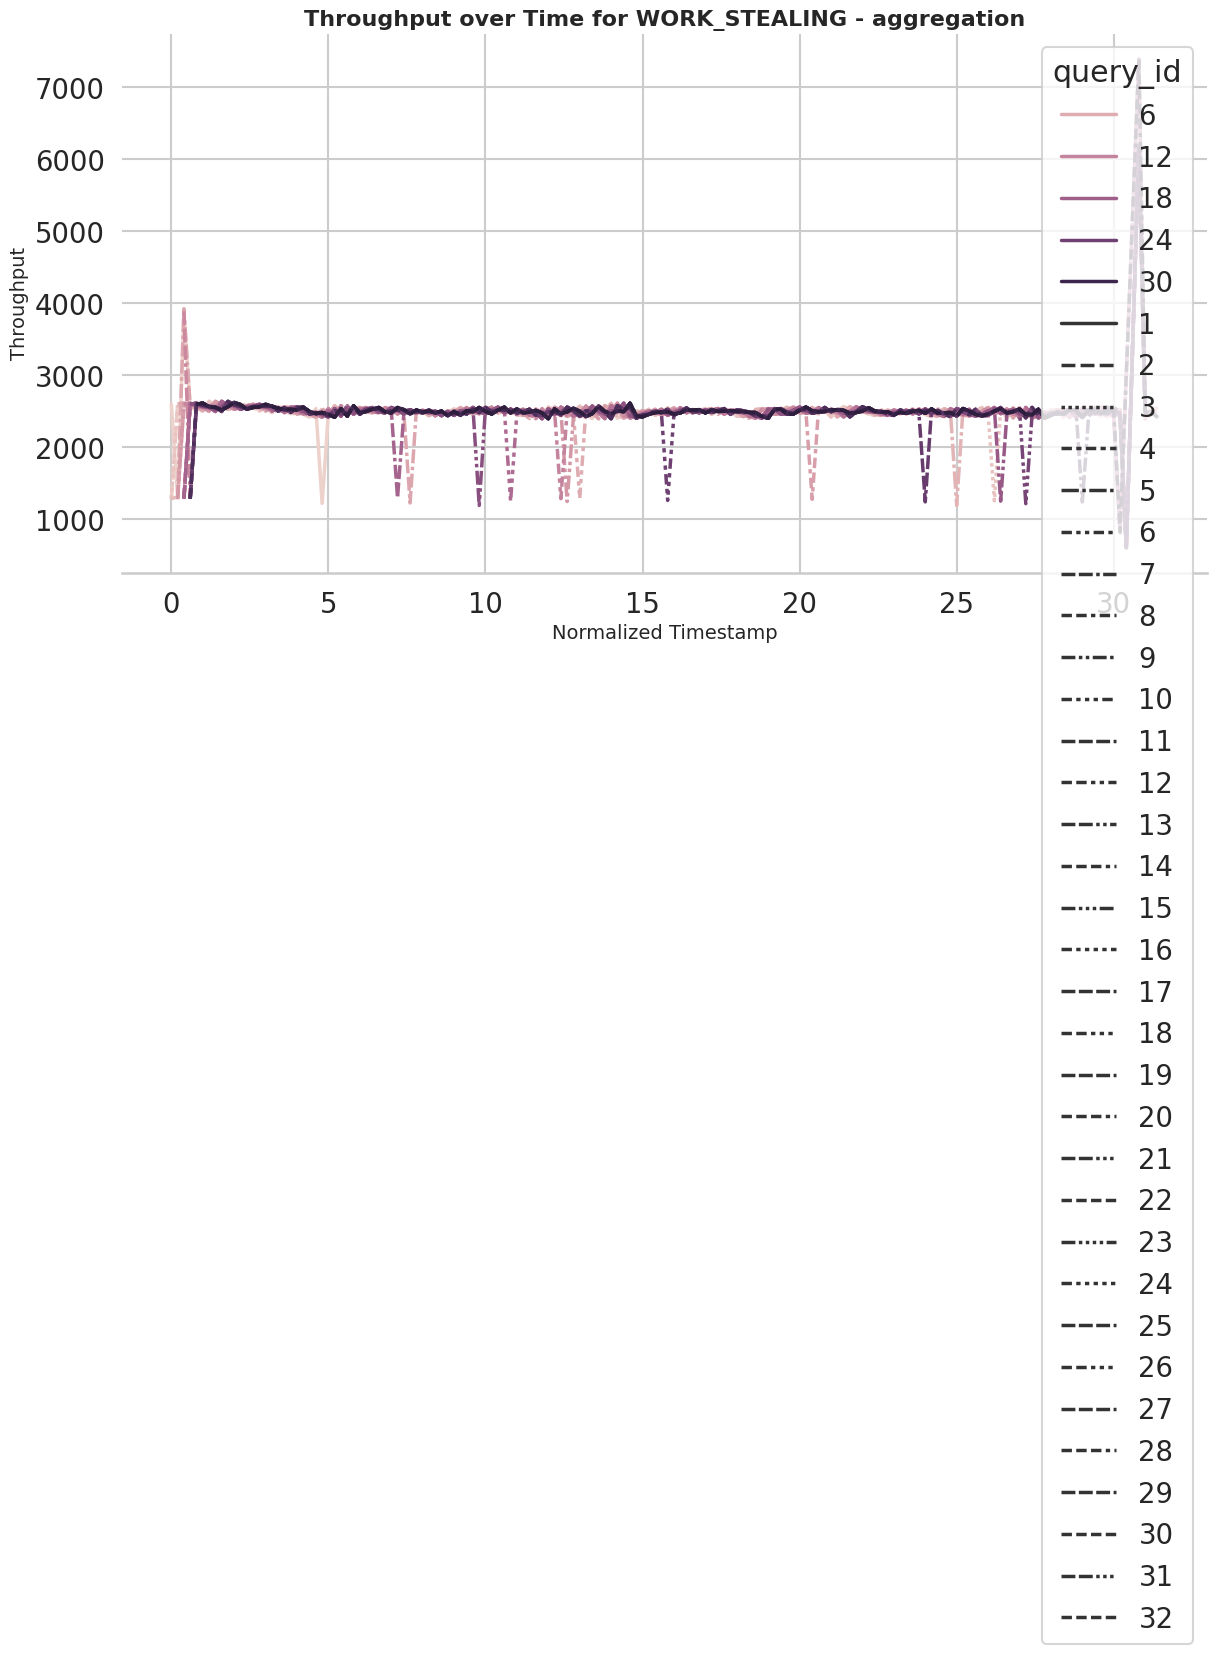

/tmp/ipykernel_76657/3071497265.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


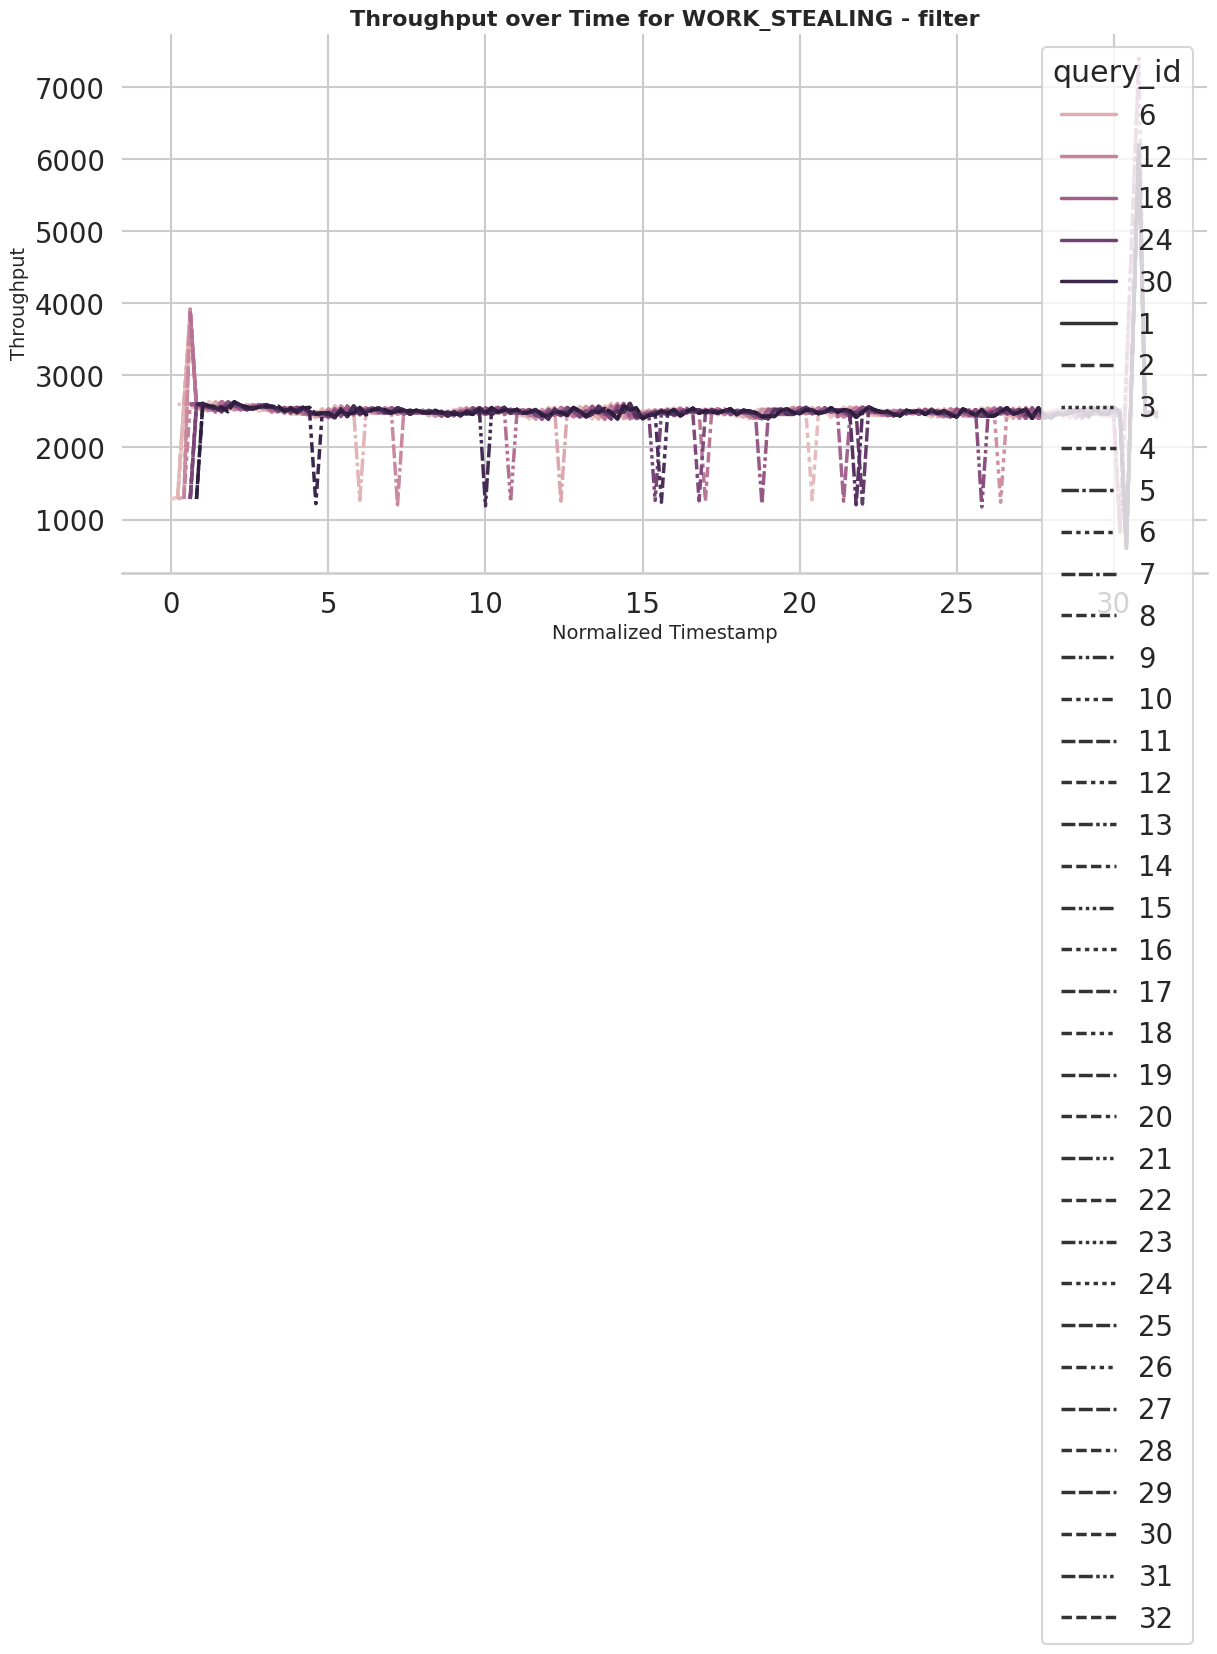

/tmp/ipykernel_76657/3071497265.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


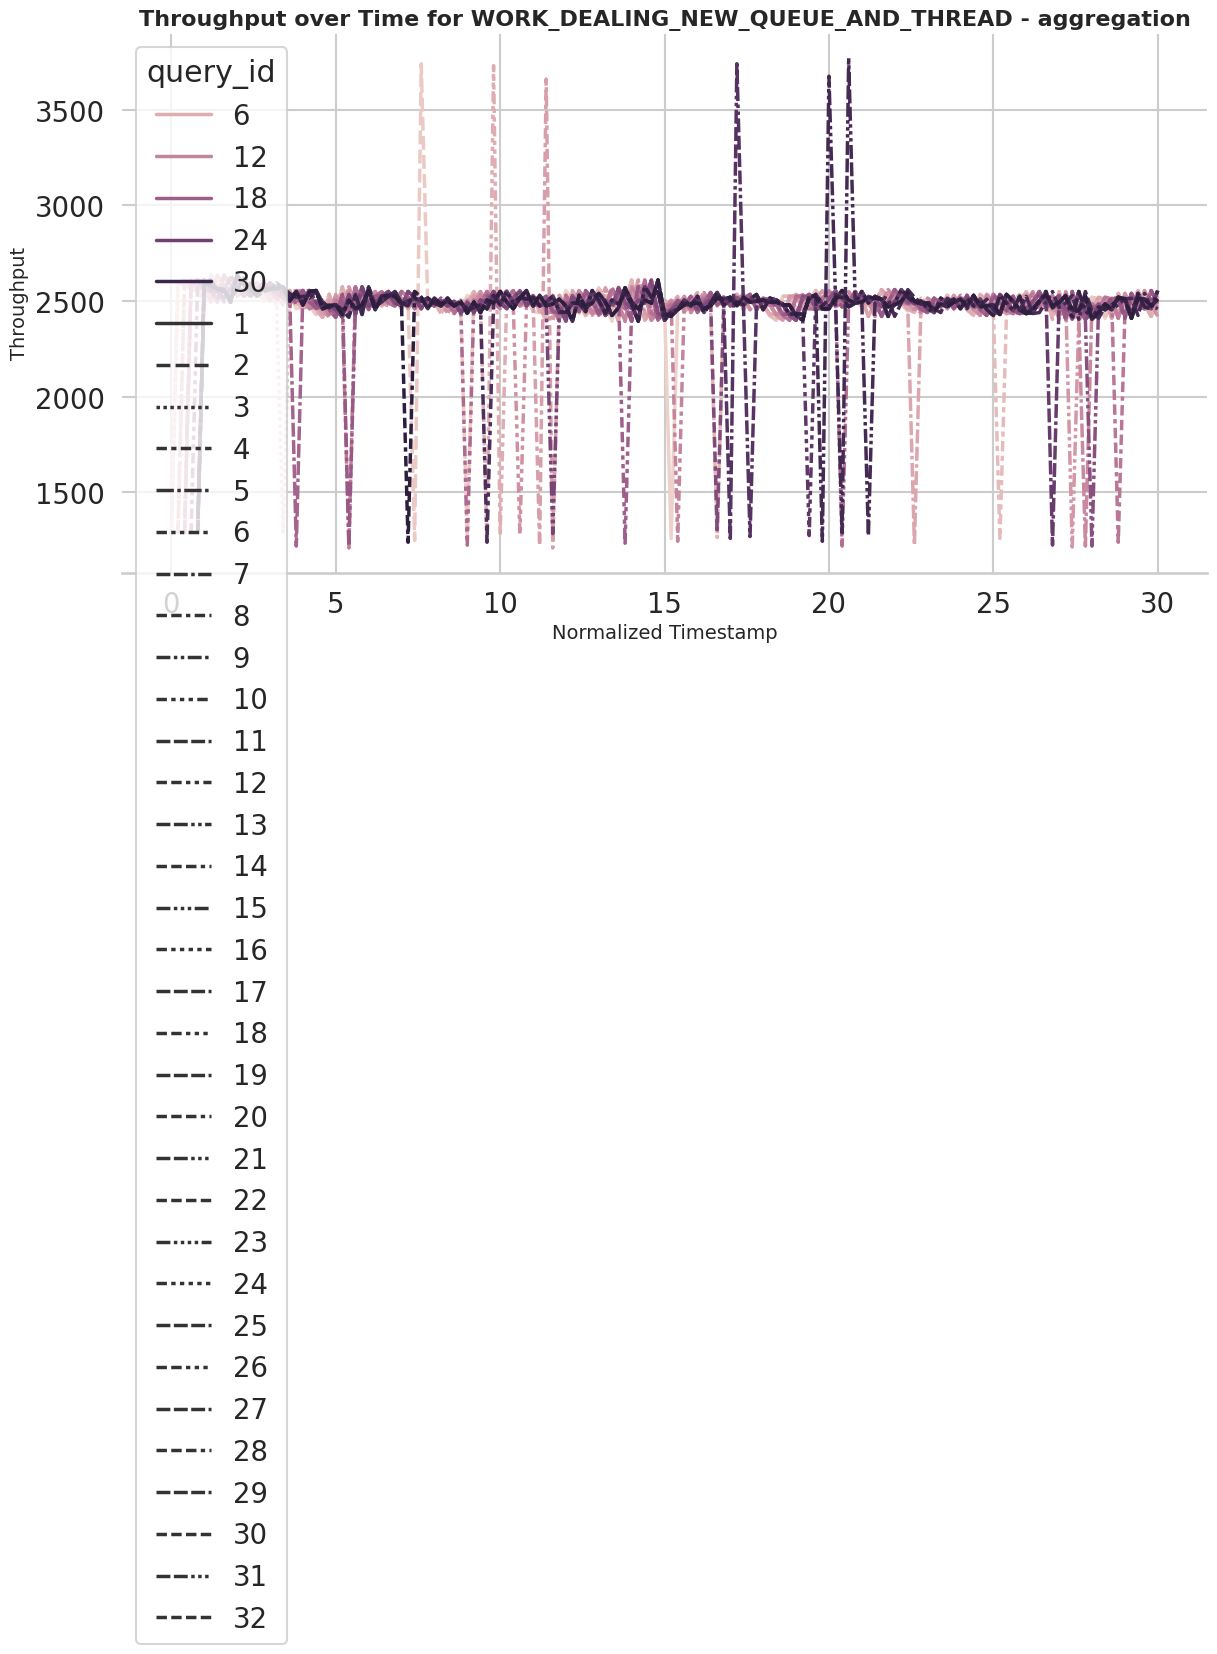

/tmp/ipykernel_76657/3071497265.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


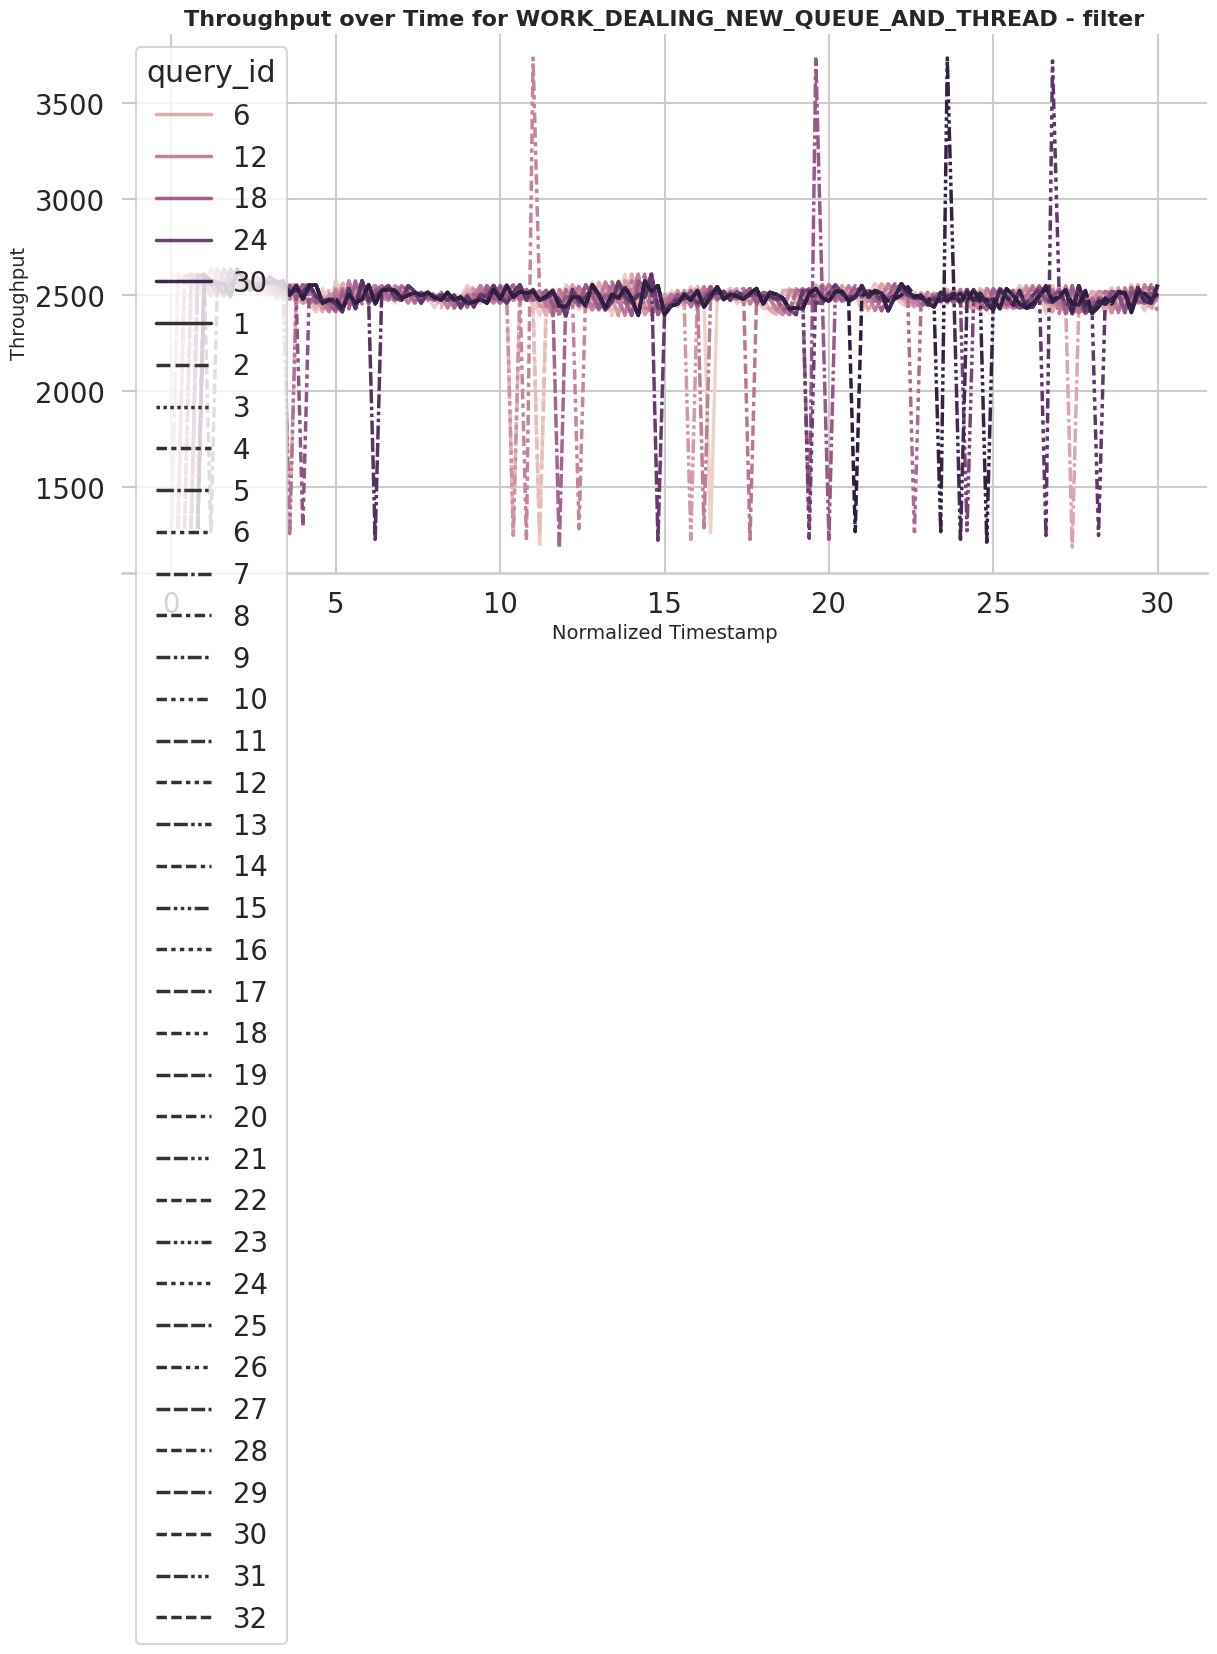

In [4]:
# Plot 2: Each query separately (hue: query_id) but separate plots per resource assignment and per query
resource_assignments = df['resourceAssignment'].unique()
queries = df['query'].unique()
for resource in resource_assignments:
    for query in queries:
        resource_query_df = df[(df['resourceAssignment'] == resource) & (df['query'] == query)]
        #smoothed_df = smooth_throughput(resource_query_df)
        
        plt.figure(figsize=(14, 7))
        ax = sns.lineplot(data=resource_query_df, x='normalized_timestamp', y='throughput', hue='query_id', style='query_id', linewidth=2.5)

        plt.title(f'Throughput over Time for {resource} - {query}', fontsize=16, fontweight='bold')
        plt.xlabel('Normalized Timestamp', fontsize=14)
        plt.ylabel('Throughput', fontsize=14)
        #plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14,
        #    loc='upper center',
        #    bbox_to_anchor=(0.5, 1.15),
        #    ncol=2,
        #    frameon=False) 
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

In [5]:
# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the latency data using rolling mean
def smooth_latency(df, window_size):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Function to smooth only the latency data using Exponential Moving Average
def smooth_latency_ema(df, span):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    return df
    
df = pd.read_csv("latency_results_nebulastream_concat.csv")
df['normalized_start_timestamp'] = df['normalized_start_timestamp'] / 1000
df['normalized_end_timestamp'] = df['normalized_end_timestamp'] / 1000
df['latency_in_ms'] = df['latency'] * 1000
df['latency_in_us'] = df['latency'] * 1000 * 1000
df

,query_id,number_of_tasks,normalized_start_timestamp,normalized_end_timestamp,latency,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType,latency_in_ms,latency_in_us
0,1,1,0.000,0.000,2.019000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.002019,2.019
1,3,1,0.043,0.043,1.869000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001869,1.869
2,2,1,0.051,0.051,6.860000e-07,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.000686,0.686
3,1,1,0.100,0.100,2.343000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.002343,2.343
4,4,1,0.115,0.115,1.222000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001222,1.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38700,13,1,30.384,30.384,4.360000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.004360,4.360
38701,14,1,30.384,30.384,2.211000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002211,2.211
38702,9,1,30.385,30.385,2.103000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.002103,2.103
38703,12,1,30.390,30.390,6.759000e-06,8192,200000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.006759,6.759


/tmp/ipykernel_76657/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_76657/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_76657/2020987545.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


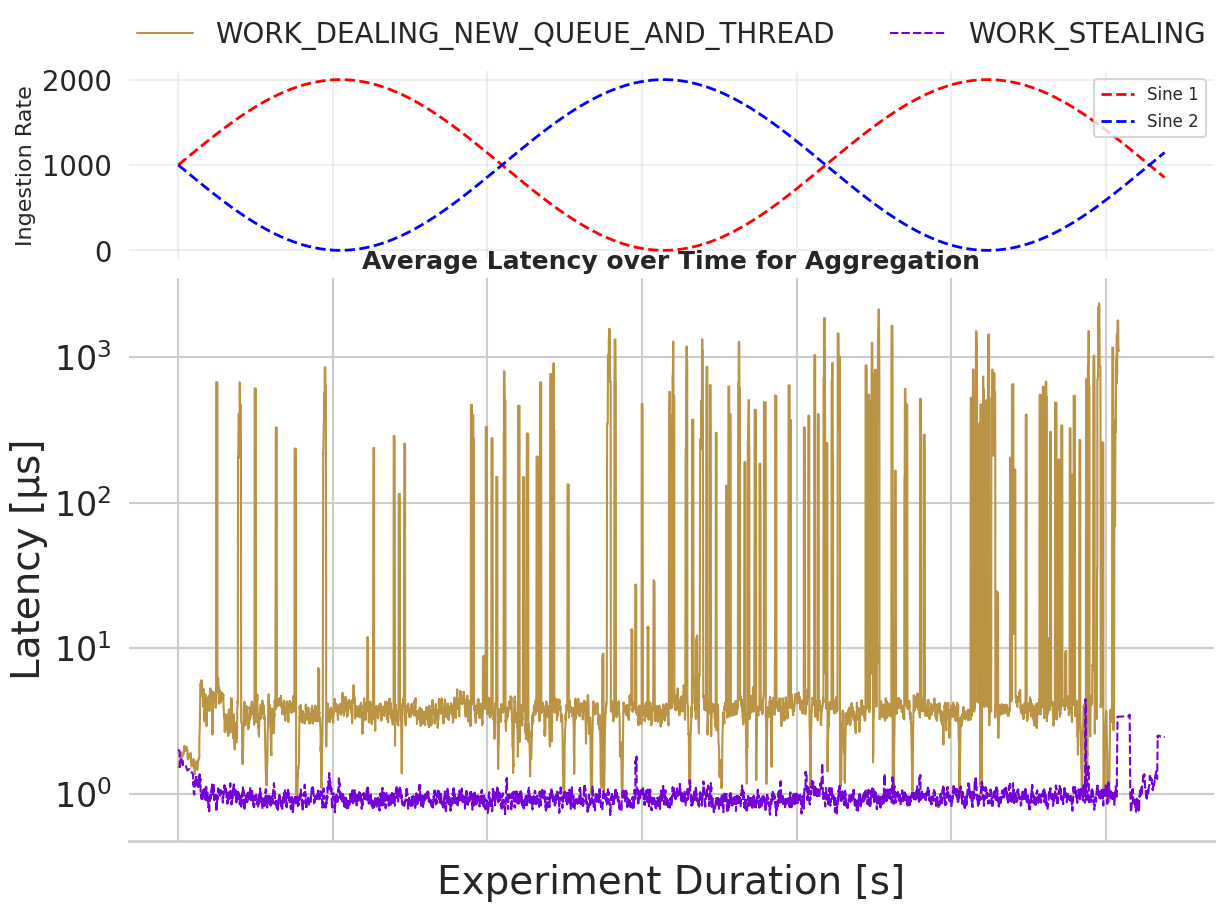

/tmp/ipykernel_76657/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_76657/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_76657/2020987545.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


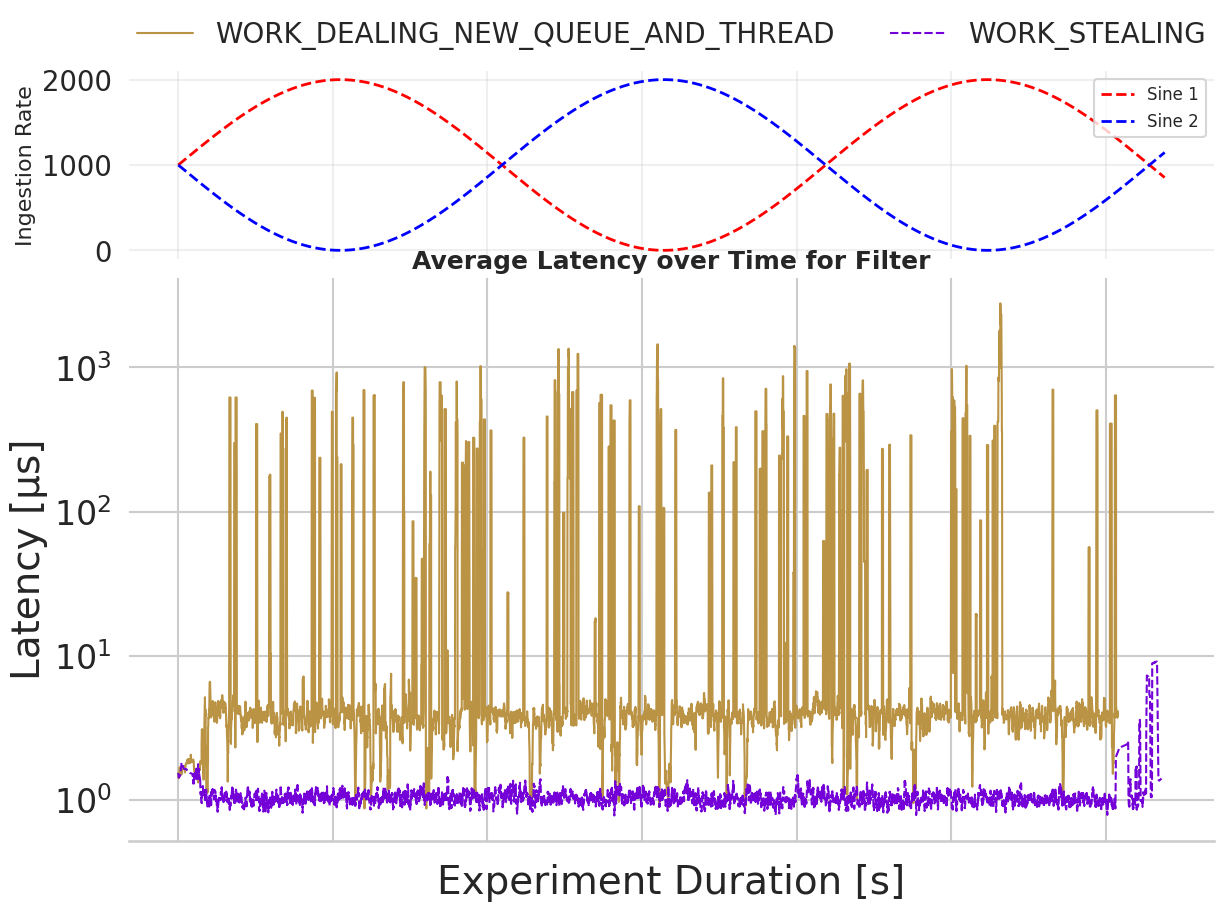

In [6]:
import matplotlib.gridspec as gridspec

# Only keep timestamps in the range of
tmp_df = df[(df['normalized_start_timestamp'] >= 0) & (df['normalized_start_timestamp'] < 30000)]
min_timestamp = tmp_df['normalized_start_timestamp'].min()
tmp_df['normalized_start_timestamp'] = tmp_df['normalized_start_timestamp'] - min_timestamp

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = tmp_df.groupby(['query', 'normalized_start_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = tmp_df.groupby('normalized_start_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    # Create a figure with 2 subplots (sine waves on top, latency plot below)
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3], hspace=0.05)  # Adjust height_ratios as needed

    # Top subplot: Sine waves
    ax_top = plt.subplot(gs[0])
    x_sin = np.linspace(0, df_sum['normalized_start_timestamp'].max(), 10000)
    freq = 0.3
    phase_shift = 0
    amplitude = 1000
    y_sin_1 = amplitude * (np.sin(freq * (x_sin - phase_shift))) + amplitude
    y_sin_2 = amplitude * (np.sin(-1 * freq * (x_sin - phase_shift))) + amplitude

    # Plot sine waves
    ax_top.plot(x_sin, y_sin_1, color='red', linestyle='--', linewidth=2, label='Sine 1')
    ax_top.plot(x_sin, y_sin_2, color='blue', linestyle='--', linewidth=2, label='Sine 2')
    ax_top.set_ylabel('Ingestion Rate', fontsize=16)
    ax_top.legend(fontsize=12, loc='upper right')
    ax_top.grid(True, alpha=0.3)
    ax_top.set_xticklabels([])  # Hide x-axis labels for the top plot
    #ax_top.set_title('Sine Waves (f=1, A=1000, offset=1000)', fontsize=14)
    sns.despine(left=True, bottom=True, ax=ax_top)

    # Bottom subplot: Latency plot
    ax_bottom = plt.subplot(gs[1], sharex=ax_top)  # Share x-axis with top plot
    query_df = df_sum[df_sum['query'] == query]
    smoothed_df = smooth_latency(query_df, 10)

    # Plot smoothed latency data
    sns.lineplot(
        data=smoothed_df,
        x='normalized_start_timestamp',
        y='latency_in_us',
        hue='resourceAssignment',
        style='resourceAssignment',
        palette=custom_palette,
        hue_order=hue_order,
        linewidth=1.5,
        ax=ax_bottom
    )

    # Customize bottom plot
    ax_bottom.set_title(f'Average Latency over Time for {str(query).capitalize()}', fontsize=18, fontweight='bold')
    ax_bottom.set_xlabel('Experiment Duration [s]', fontsize=28)
    ax_bottom.set_ylabel('Latency [µs]', fontsize=28)
    ax_bottom.tick_params(axis='x', labelsize=24, rotation=0)
    ax_bottom.tick_params(axis='y', labelsize=24)
    ax_bottom.set_yscale('log')
    sns.despine(left=True, ax=ax_bottom)

    # Legend for latency plot
    handles, labels = ax_bottom.get_legend_handles_labels()
    ax_bottom.legend(
        title='',
        handles=handles,
        labels=labels,
        fontsize=20,
        title_fontsize=18,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.5),
        ncol=2,
        frameon=False
    )

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_latency_with_sine.pdf'))
    plt.show()
    plt.close(fig)  # Close the figure to free memory


/tmp/ipykernel_76657/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_76657/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(


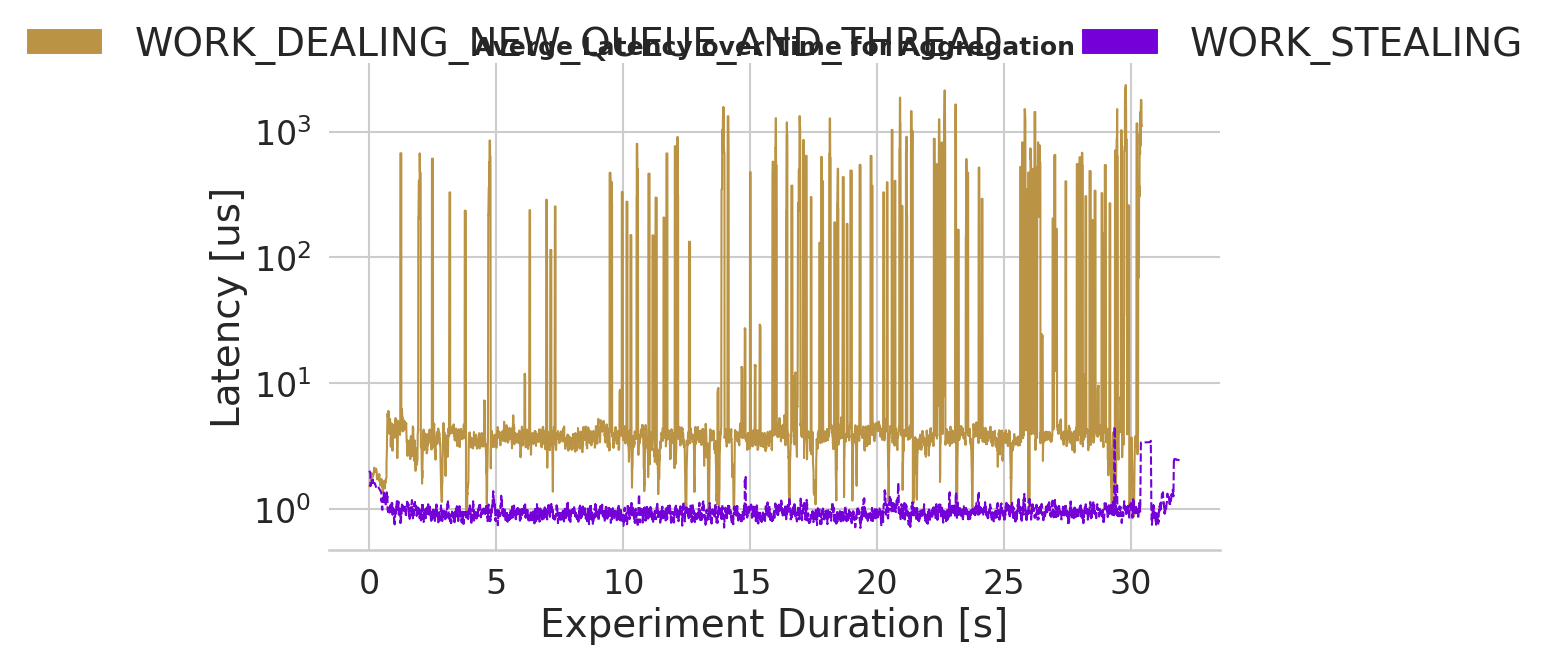

/tmp/ipykernel_76657/3787161799.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_76657/3787161799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(


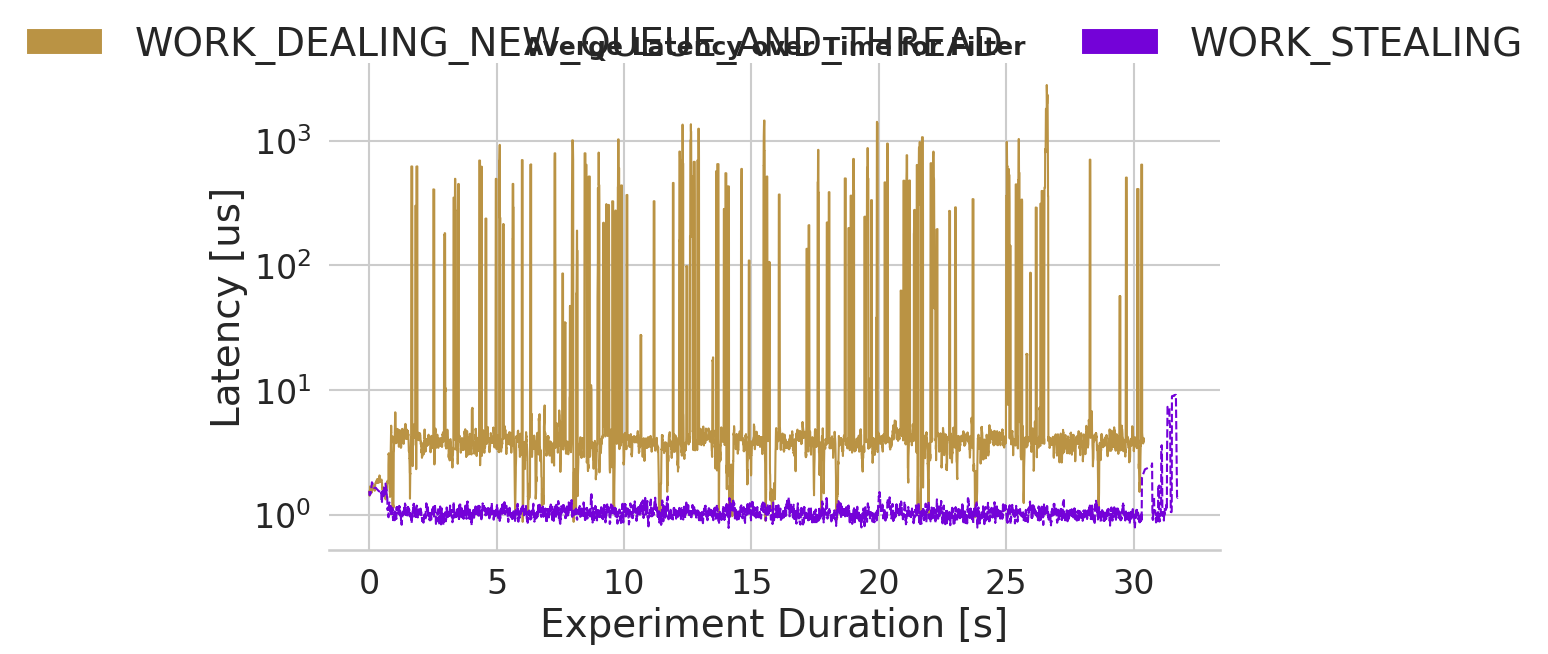

In [7]:
# Only keep timestamps in the range of 
tmp_df = df[(df['normalized_start_timestamp'] >= 0) & (df['normalized_start_timestamp'] < 30000)]
min_timestamp = tmp_df['normalized_start_timestamp'].min()
tmp_df['normalized_start_timestamp'] = tmp_df['normalized_start_timestamp'] - min_timestamp

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = tmp_df.groupby(['query', 'normalized_start_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = tmp_df.groupby('normalized_start_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    plt.subplots_adjust(top=0.85, bottom=0.15)  # Adjust top and bottom margins

    query_df = df_sum[df_sum['query'] == query]

    # Smooth the throughput data
    smoothed_df = smooth_latency(query_df, 10)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_start_timestamp', y='latency_in_us', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=1.5)

    #plt.axhline(y=10, color='gray', linestyle='--', alpha=0.7)

    plt.title(f'Averge Latency over Time for {str(query).capitalize()}', fontsize=18, fontweight='bold')
    plt.xlabel('Experiment Duration [s]', fontsize=28)
    plt.xticks(rotation=0, fontsize=24)
    plt.yticks(rotation=0, fontsize=24)
    plt.ylabel('Latency [us]', fontsize=28)
    plt.legend(title='', handles=legend_handles, fontsize=28, title_fontsize=18, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_latency_over_experiment_duration_work_dealing_variable_ingestion_rate.pdf'))
    plt.show()

/tmp/ipykernel_76657/2494488268.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


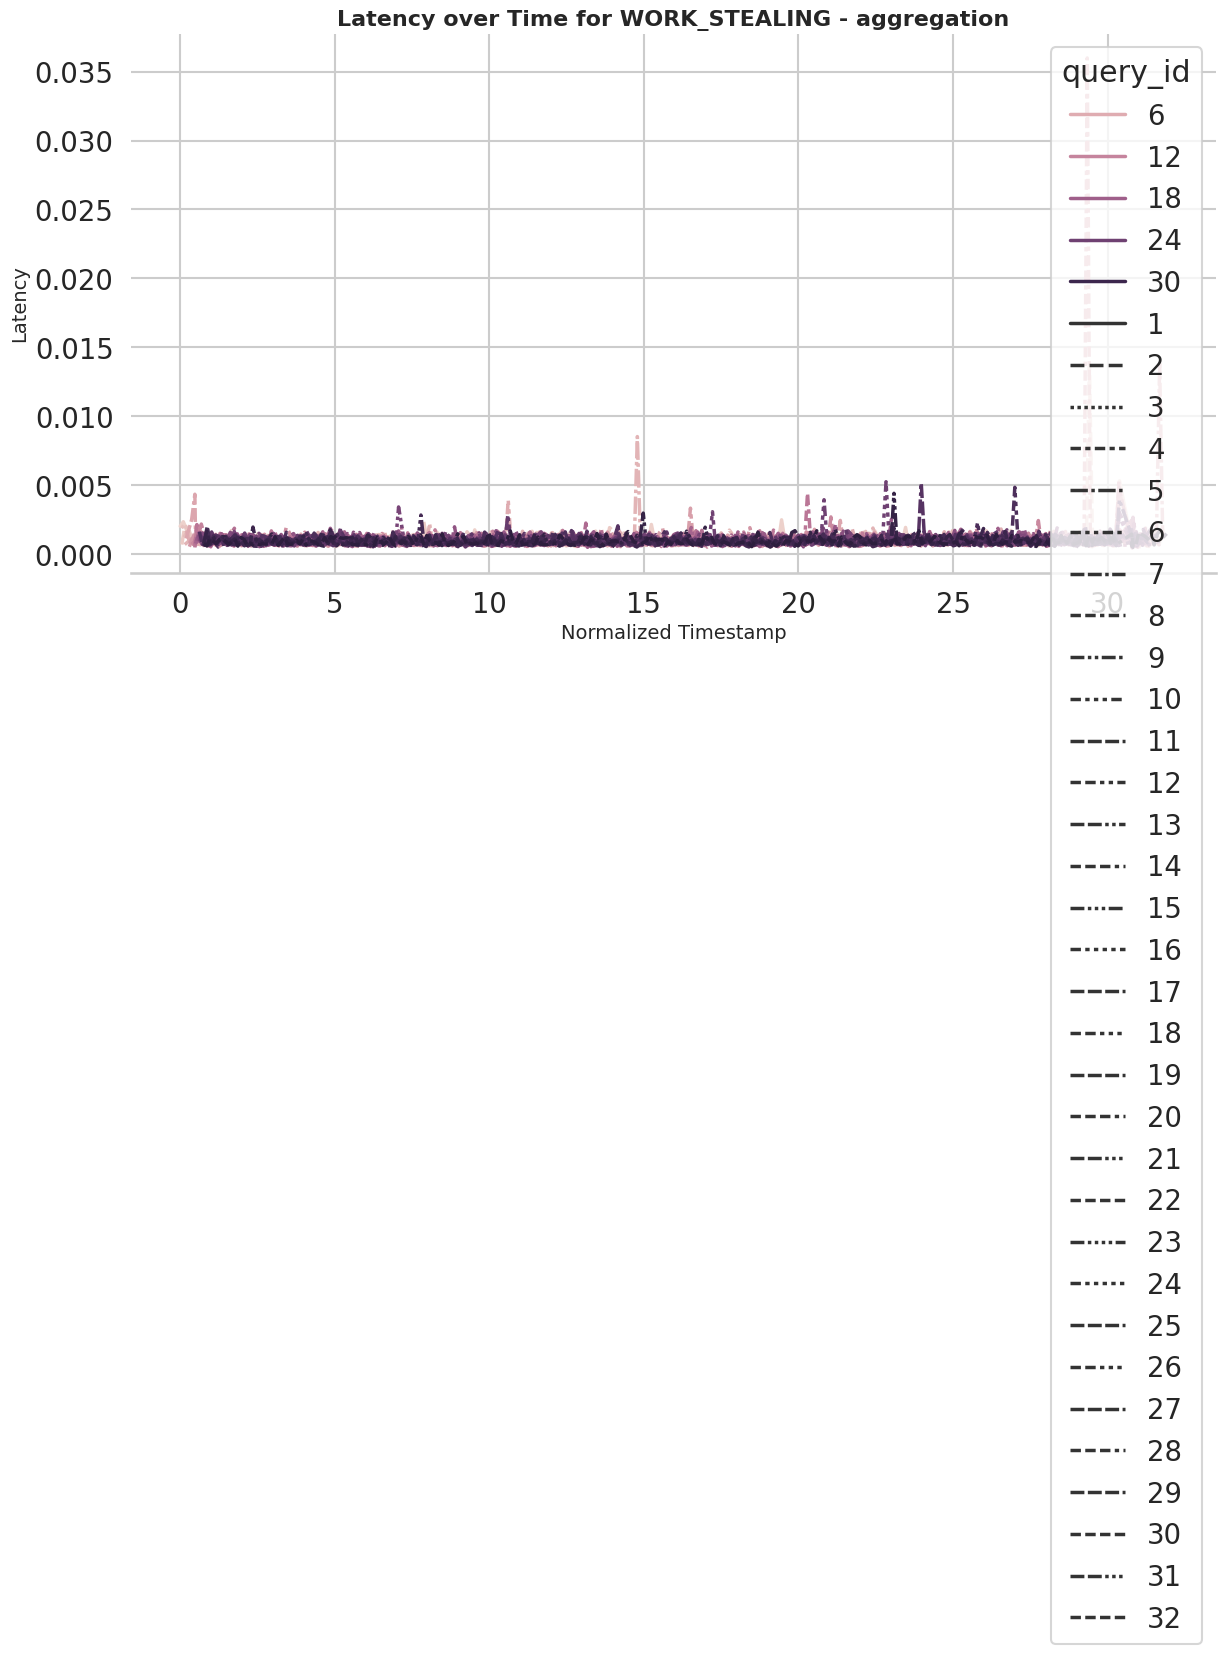

/tmp/ipykernel_76657/2494488268.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


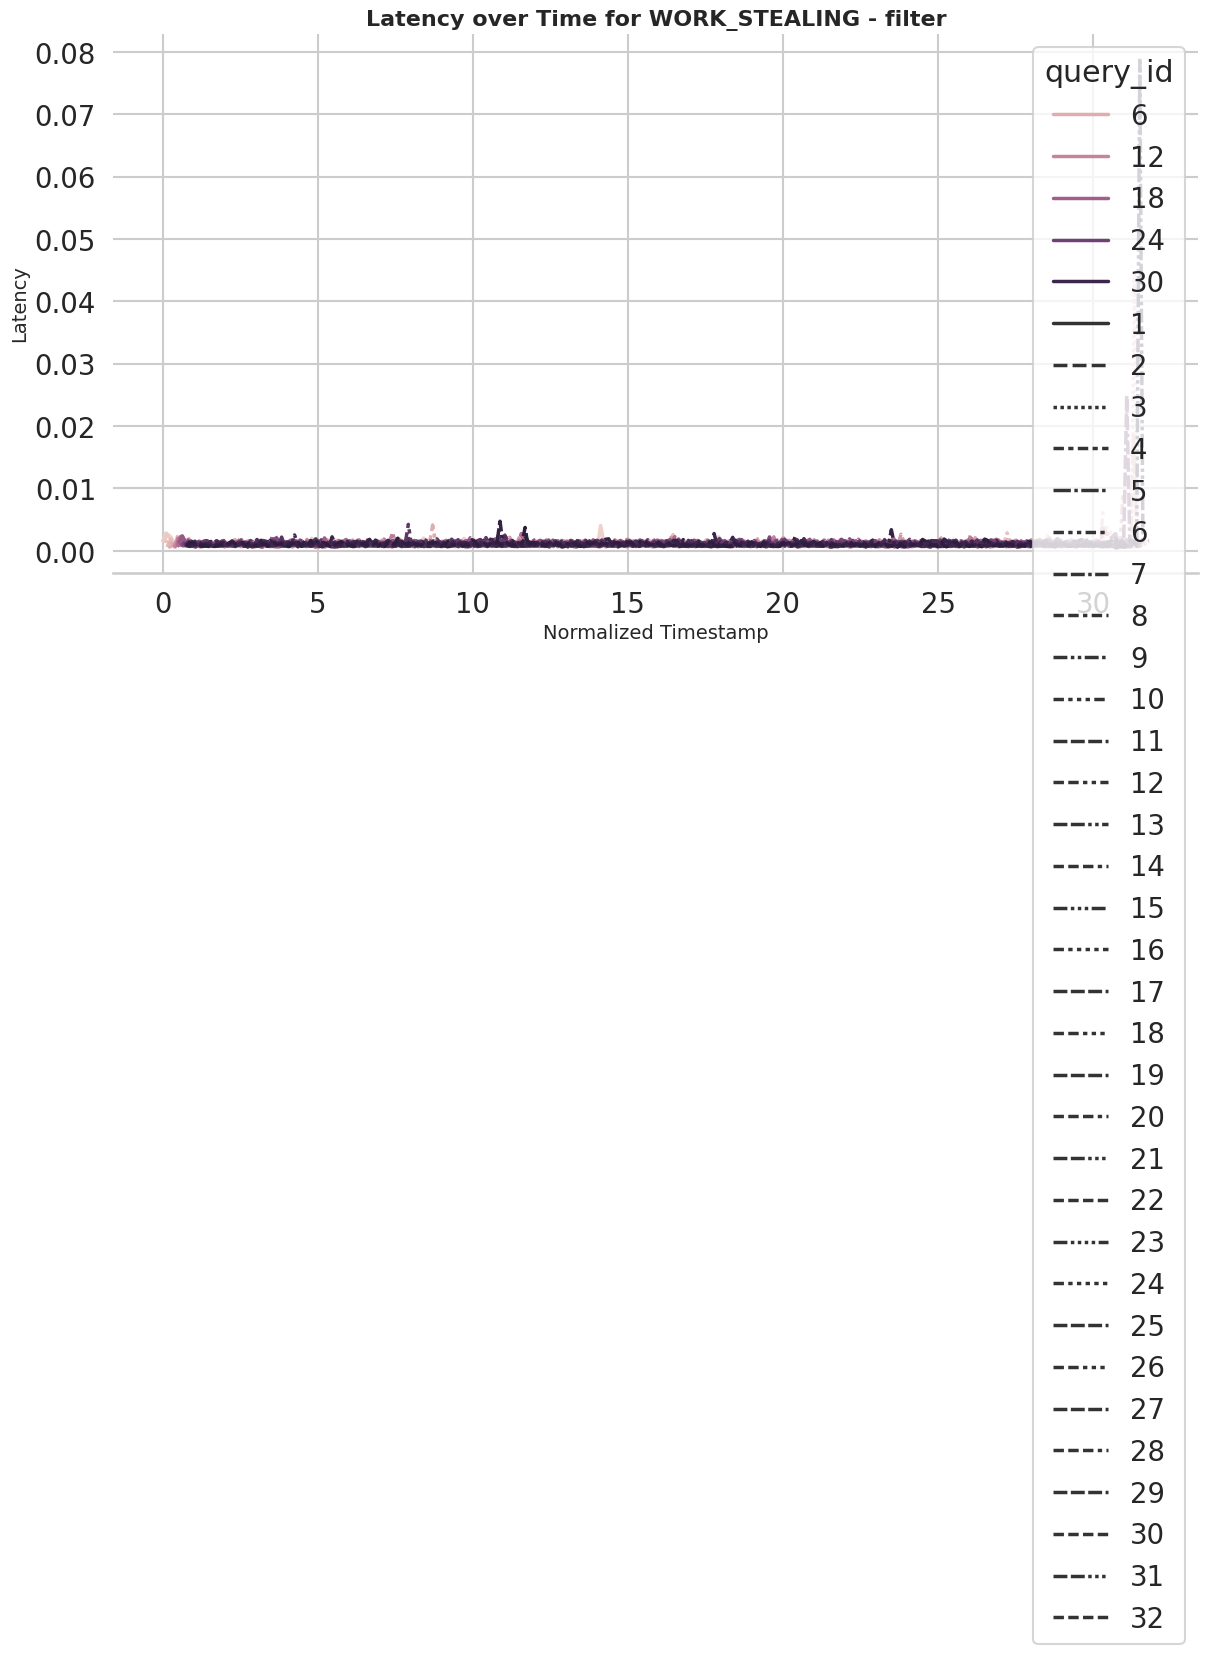

/tmp/ipykernel_76657/2494488268.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


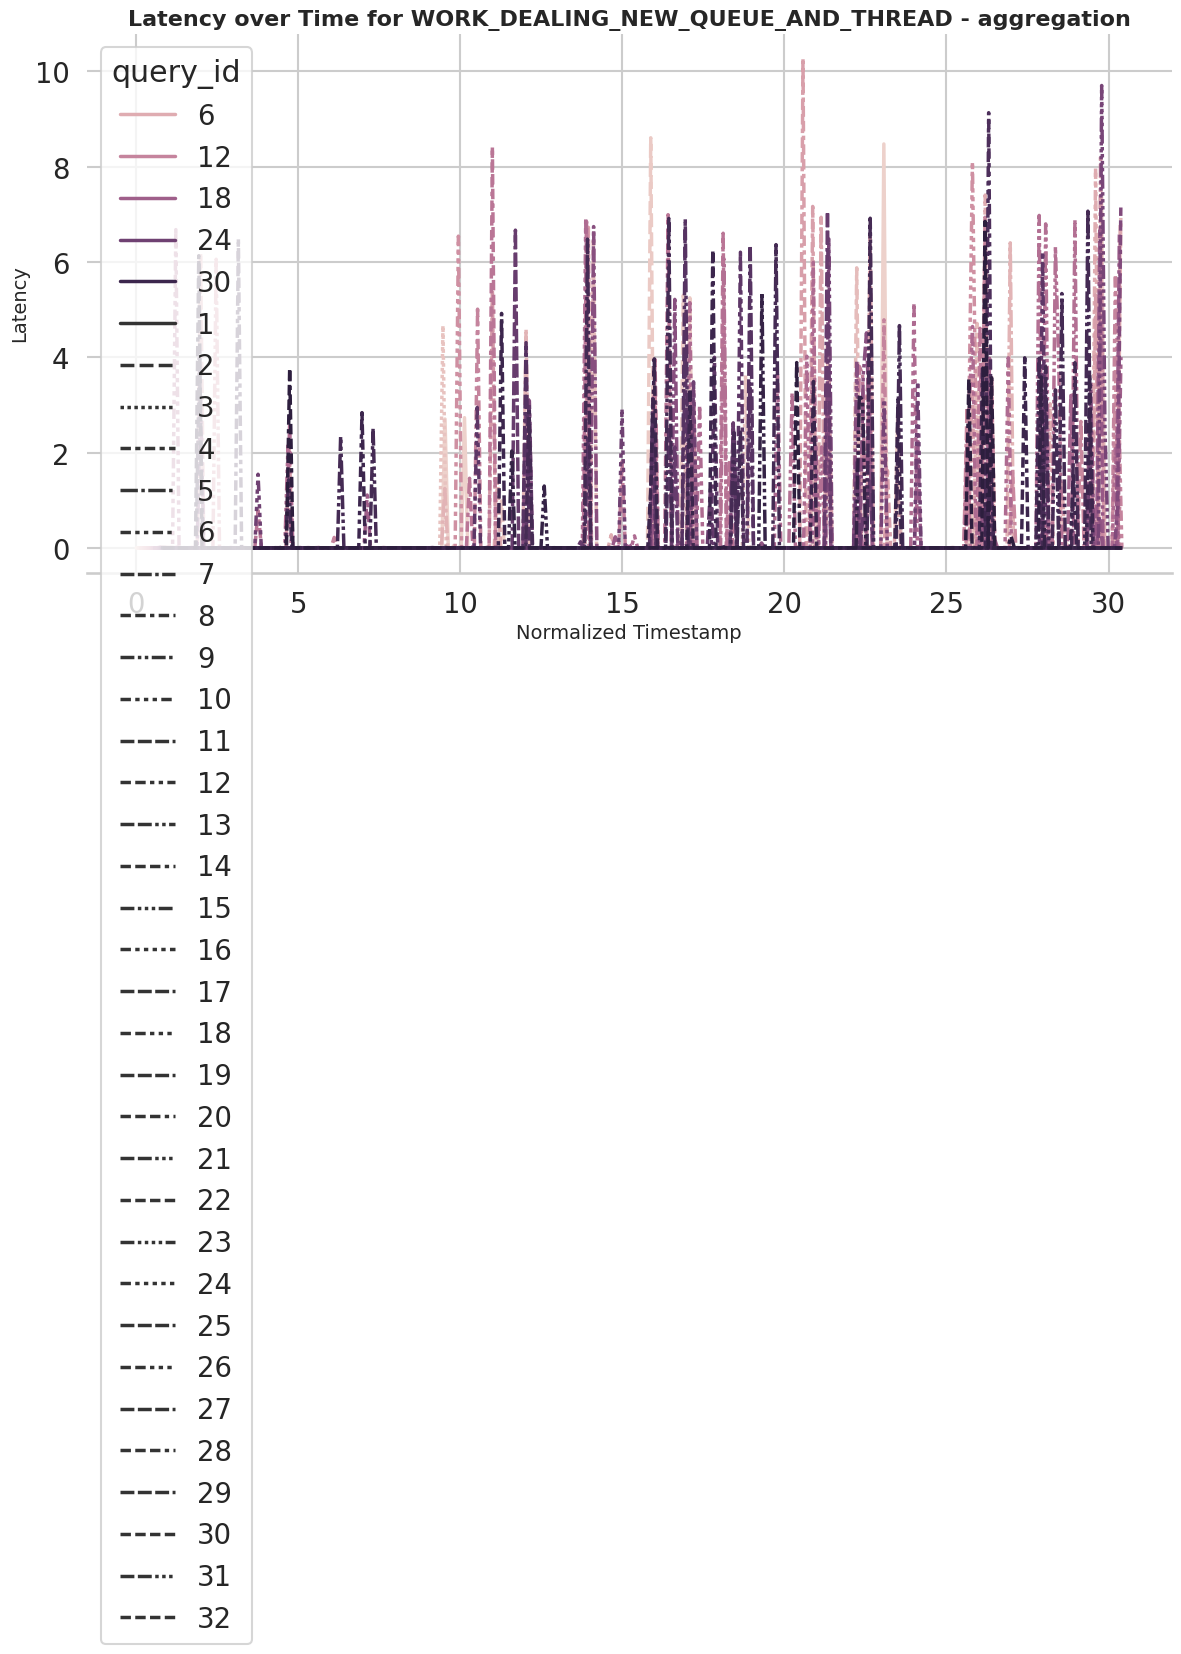

/tmp/ipykernel_76657/2494488268.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


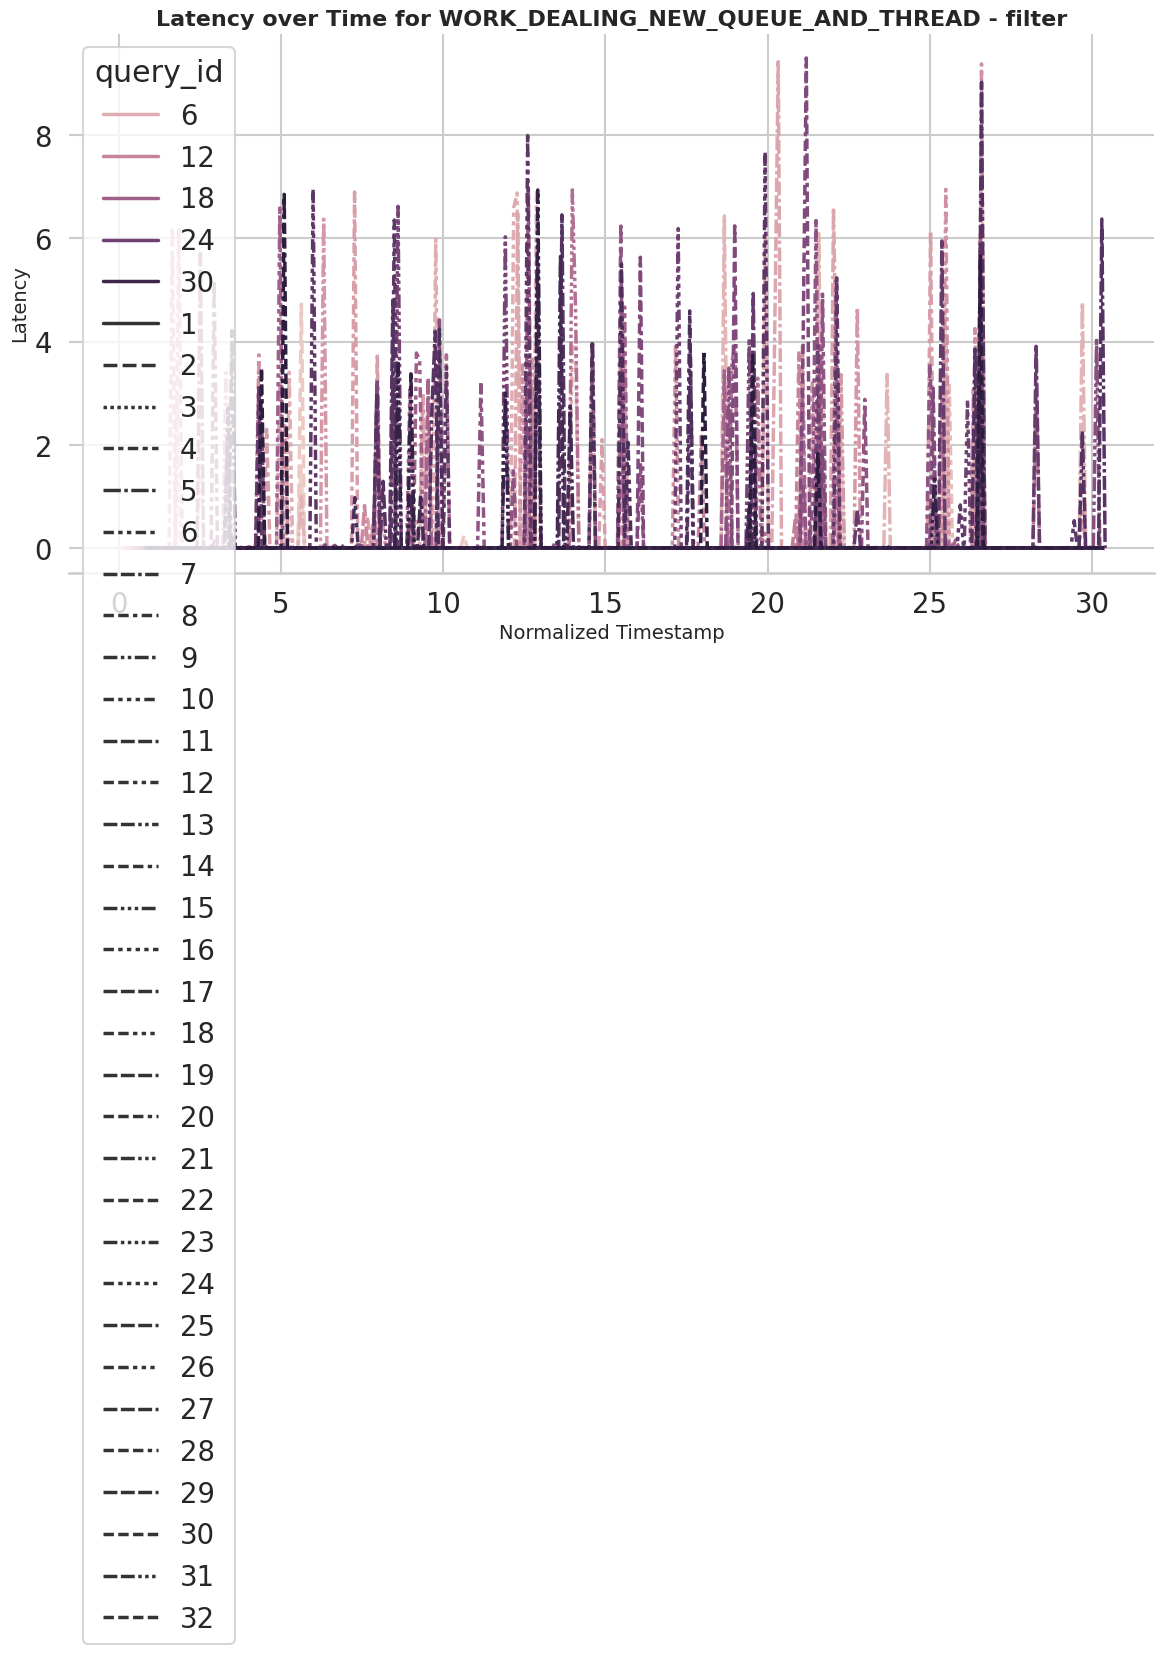

In [8]:
# Plot 2: Each query separately (hue: query_id) but separate plots per resource assignment and per query
resource_assignments = df['resourceAssignment'].unique()
queries = df['query'].unique()
for resource in resource_assignments:
    for query in queries:
        resource_query_df = df[(df['resourceAssignment'] == resource) & (df['query'] == query)]
        #smoothed_df = smooth_throughput(resource_query_df)
        
        plt.figure(figsize=(14, 7))
        ax = sns.lineplot(data=resource_query_df, x='normalized_start_timestamp', y='latency_in_ms', hue='query_id', style='query_id', linewidth=2.5)

        plt.title(f'Latency over Time for {resource} - {query}', fontsize=16, fontweight='bold')
        plt.xlabel('Normalized Timestamp', fontsize=14)
        plt.ylabel('Latency', fontsize=14)
        #plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14,
        #    loc='upper center',
        #    bbox_to_anchor=(0.5, 1.15),
        #    ncol=2,
        #    frameon=False) 
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()